## cnn 训练

## CNN 使用字符分割的验证码识别流程

### 1. 图像预处理‌

-‌‌ ‌灰度化与二值化‌：将彩色验证码转为灰度图，并通过阈值化（如 Otsu 算法）生成二值图像，突出字符轮廓‌35。
‌去噪与形态学优化‌：使用高斯模糊消除噪声，通过膨胀（Dilation）和腐蚀（Erosion）连接断裂字符‌35。
‌示例代码‌：
python
Copy Code


### 2. 字符分割‌

‌投影法‌：根据水平/垂直像素投影分布定位字符边界，适合字符间距较大的场景‌23。
‌连通域分析‌：提取图像中的连通区域，筛选面积和宽高符合字符特征的区域‌24。
‌区域生长法‌：从种子点扩展，合并相邻像素形成字符区域，适用于无粘连字符‌3。
‌粘连字符处理‌：对复杂粘连场景，需结合形态学操作或基于深度学习的语义分割（如 U-Net）‌34。
‌3. 数据准备‌
‌单字符标注‌：将分割后的单字符图像按类别（0-9、A-Z、a-z）存储至对应文件夹‌12。
‌数据增强‌：对单字符图像进行旋转（±10°）、平移（±5%）、缩放（0.9–1.1 倍）以扩充数据集‌25。
‌标准化输入‌：统一图像尺寸（如 32×32 像素），归一化像素值至 [0,1]‌13。
‌4. 单字符 CNN 模型训练‌
‌网络结构‌：
python
Copy Code
model = Sequential([  
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)),  
    MaxPooling2D((2,2)),  
    Conv2D(64, (3,3), activation='relu'),  
    Flatten(),  
    Dense(62, activation='softmax')  # 输出 62 类字符概率  
])  
‌损失函数与优化‌：使用交叉熵损失（CategoricalCrossentropy）和 Adam 优化器‌12。
‌训练策略‌：批量大小设为 32–64，训练轮数（Epochs）约 50–100，验证集准确率可达 90% 以上‌14。
‌5. 后处理与结果组合‌
‌序列还原‌：将单字符预测结果按原始验证码顺序拼接，形成完整字符串‌14。
‌纠错规则‌：结合字符上下文（如固定长度、字符类型）修正异常结果（如字母与数字混合场景）‌

In [ ]:
import cv2  
import numpy as np
import os
import matplotlib.pyplot as plt

def show_gray(image):  
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def show_rgb(image):  
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def preprocess_captcha(image_path):  
    # 1. 灰度化与二值化  
    img = cv2.imread(image_path)  
    # show_rgb(img)
    # 转换为灰度图像
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    # show_gray(gray)
    # 自适应阈值二值化
    binary = cv2.adaptiveThreshold(  
        gray, 255,  
        cv2.ADAPTIVE_THRESH_MEAN_C,  
        cv2.THRESH_BINARY_INV, 15, 20
    )  
    # show_gray(binary)
    # 2. 去噪与形态学优化  
    # 高斯模糊
    blurred = cv2.GaussianBlur(binary, (3, 3), 0)  
    # show_gray(blurred)
    # 形态学操作
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)) 
    # 膨胀与腐蚀 
    dilated = cv2.dilate(blurred, kernel, iterations=1)  
    # 腐蚀
    eroded = cv2.erode(dilated, kernel, iterations=1)  
    # show_gray(eroded)

    # 3. 二次二值化与降噪  
    _, thresh = cv2.threshold(eroded, 127, 255, cv2.THRESH_BINARY)  
    
    # 图片轮廓的三个像素点自动填充为黑色
    h, w = thresh.shape
    thresh[0:3, :] = 0
    thresh[:, 0:3] = 0
    thresh[h-3:h, :] = 0
    thresh[:, w-3:w] = 0
    # show_gray(thresh)

    # 连通区域分析
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=8)

    # 过滤小区域
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] < 12:
            thresh[labels == label] = 0  # 转为黑色

    # contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
    # for cnt in contours:  
    #     if cv2.contourArea(cnt) < 1:  
    #         cv2.drawContours(thresh, [cnt], -1, 0, -1)  

    return thresh  

# image_path = "D:\\file\\vscode\\project\\captcha_ocr\\data\\ztg7_20250220140656835.png"
image_path = 'D:\\vscode\\project\\captcha_ocr\\data\\ztg7_20250220140656835.png'
# 获取目录下所有png文件
image_dir = 'D:\\vscode\\project\\captcha_ocr\\data\\'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# 处理每个图片文件
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    print(image_file)
    processed_image = preprocess_captcha(image_path)
    show_gray(processed_image)




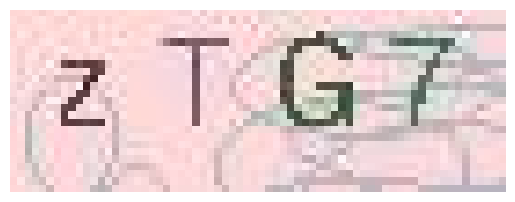

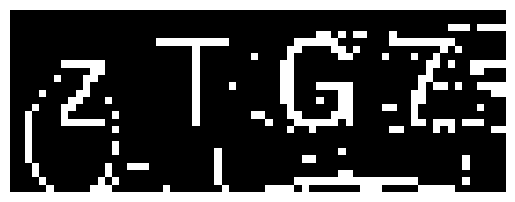

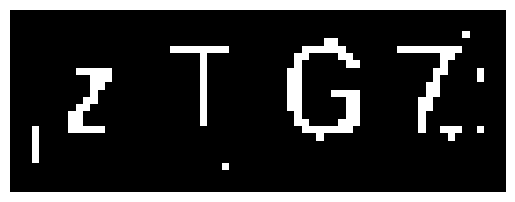

IndexError: list index out of range

In [5]:


def split_captcha(image_path):
    thresh = preprocess_captcha(image_path)  
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
    sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])  
    captchas = []  
    for i, ctr in enumerate(sorted_ctrs):  
        x, y, w, h = cv2.boundingRect(ctr)  
        roi = thresh[y:y+h, x:x+w]  
        if w > 10 and h > 10:  
            captchas.append(roi)  
    return captchas

captchas = split_captcha(image_path)
# 确保 captchas 列表中有至少4个元素
if len(captchas) < 4:
    captchas.extend([np.zeros_like(captchas[0])] * (4 - len(captchas)))

fig, axs = plt.subplots(1, 4, figsize=(10, 2.5))
for i in range(4):
    axs[i].imshow(captchas[i], cmap='gray')
plt.show()

In [ ]:
def recognize_captcha(image_path):
    captchas = split_captcha(image_path)  
    result = []  
    for captcha in captchas:  
        _, captcha = cv2.threshold(captcha, 127, 255, cv2.THRESH_BINARY)  
        captcha = cv2.resize(captcha, (30, 30))  
        captcha = captcha.reshape(-1, 30, 30, 1)  
        prediction = model.predict(captcha)  
        result.append(chr(np.argmax(prediction) + 65))  
    return ''.join(result)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(input_shape=(28, 28, 1), num_classes=36):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout层，防止过拟合
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_and_preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(28, 28))
    img = img_to_array(img) / 255.0  # 数据归一化
    return img

In [ ]:
model = build_cnn_model(input_shape=(28, 28, 1), num_classes=36)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10)  # train_images 和 train_labels 需要提前准备